<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии." data-toc-modified-id="Модель-линейной-регрессии.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии.</a></span></li><li><span><a href="#Модель-Ridge." data-toc-modified-id="Модель-Ridge.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель Ridge.</a></span></li><li><span><a href="#Модель-решающего-дерева." data-toc-modified-id="Модель-решающего-дерева.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель решающего дерева.</a></span></li><li><span><a href="#Модель-Catboost." data-toc-modified-id="Модель-Catboost.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель Catboost.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Загрузка необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit,\
RandomizedSearchCV 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from catboost import Pool, CatBoostRegressor, cv
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Зададим значения для генерации случайных величин

RANDOM_STATE = 12345

In [3]:
# Загрузим данные из файло
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
# Выведем общую информацию о дата-сете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Посчитаем кол-во пропусков

df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [6]:
# Посчитаем кол-во явных дубликатов

df.duplicated().sum()

0

Пропусков нет, явных дубликатов нет. Произведем предобработку данных. 

In [7]:
# Переведем значения стольбца 'datetime' в формат datetime
# Используем значения столбца 'datetime'  в качестве индексов дата-сета

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime',drop=True)

In [8]:
# Отсортируем значения дата-сета в соответствии со значениями индекса, проверим индекс на 
# расположение в хронологическом порядке.

df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [9]:
# Изменим размер временного интервала на 1 час, агрегируем данные внутри часового интервала
# суммированием.

df = df.resample('1H').sum()

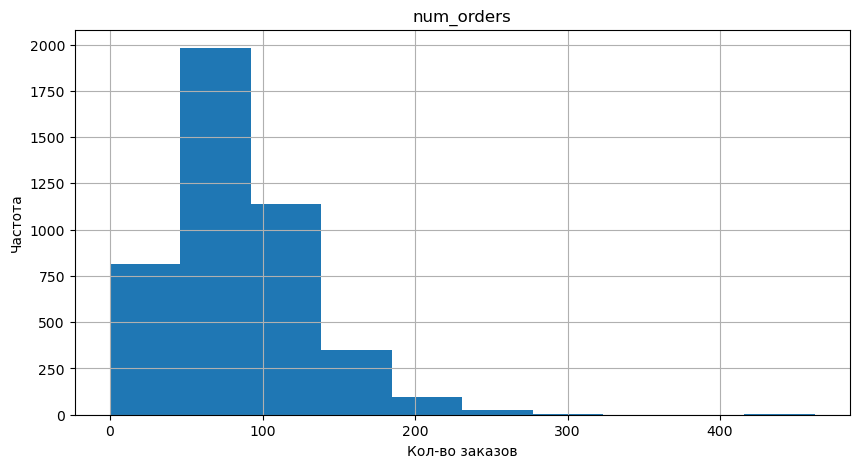

In [10]:
# Проверим распределение данных.

size = (10, 5)
df.hist(figsize=size)
plt.xlabel('Кол-во заказов')
plt.ylabel('Частота')
plt.show()

In [11]:
# Выведем первые и последние строки дата-сета.

df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


У нас есть данные по кол-ву заказов за 6 месяцев (с 1 марта по 31 автуста 2018 г.) с интервалом 1 час.

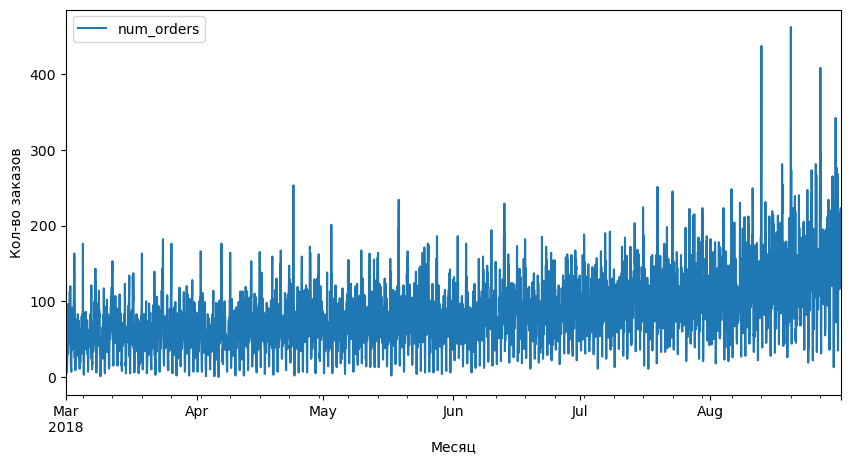

In [12]:
# Выведем график зависимости кол-ва заказов от даты и часа.

df.plot(figsize=size)
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.show()

## Анализ

In [13]:
# Выполним декомпозицию данных.

decomposed = seasonal_decompose(df) 

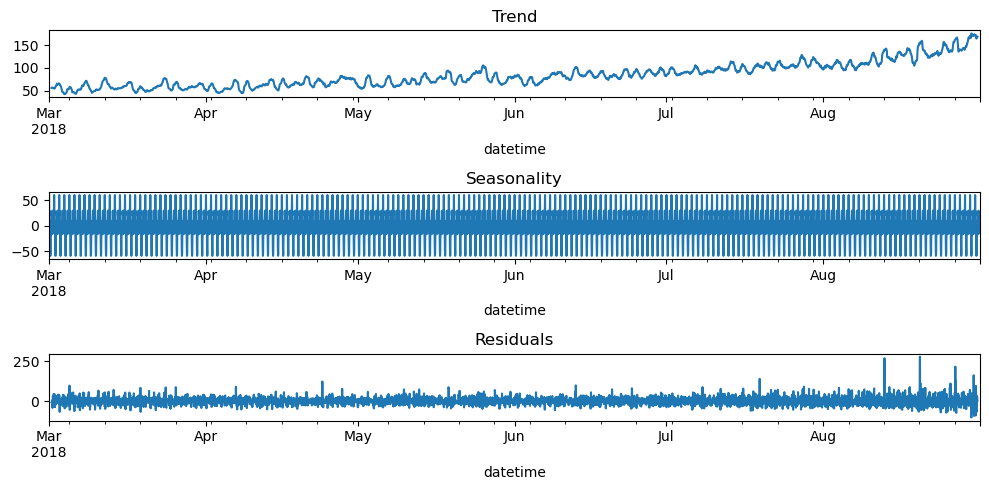

In [14]:
# Построим графики основного тренда, 'сезонности' и остатка.

plt.figure(figsize=size)
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()


Имеется явный тренд на увеличение числа заказов с марта по август.

<AxesSubplot:xlabel='datetime'>

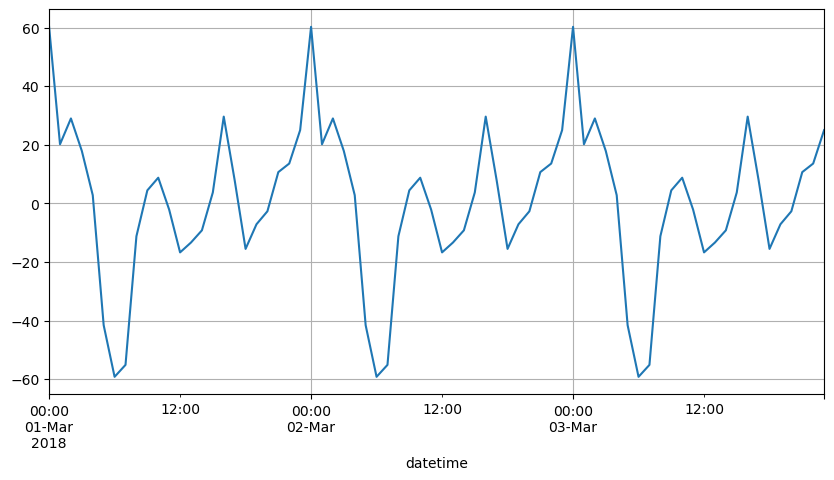

In [15]:
# Выведем график 'сезонности' на интервале в 3 дня, чтобы увидеть характерно повторяющиеся
# закономерности.

decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca(), figsize=size, grid=True)

В течении суток кол-во заказов имеет следующую тенденцию: минимум в 6 утра, растет и достигает своего пика примерно к 10-11 часам, следующий  пик больше предыдущего к 16-17 часам, самый большой пик в 24:00 и далее резкое снижение.

In [16]:
# Создадим копию нашего сета, чтобы не изменять исходный

df_day = df.copy(deep=True)

In [17]:
# Изменим размер временного интервала в копии на 1 день, агрегируем данные внутри часового интервала
# суммированием.

df_day = df_day.resample('1D').sum()

In [18]:
# Добавим столбец день недели

df_day['dayofweek'] = df_day.index.dayofweek

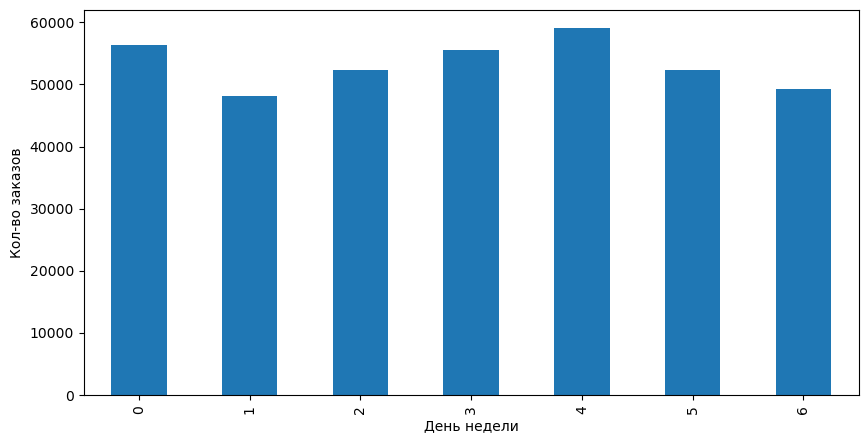

In [19]:
# Сгруппируем данные по дням недели в выведем график зависимости общего кол-ва заказов от дня недели.

df_day.groupby('dayofweek').sum().plot(kind='bar', figsize=size, legend=False)
plt.xlabel('День недели')
plt.ylabel('Кол-во заказов')
plt.show()


In [20]:
# Выполним декомпозицию данных в наше копии.

decomposed_day = seasonal_decompose(df_day['num_orders']) 

<AxesSubplot:xlabel='datetime'>

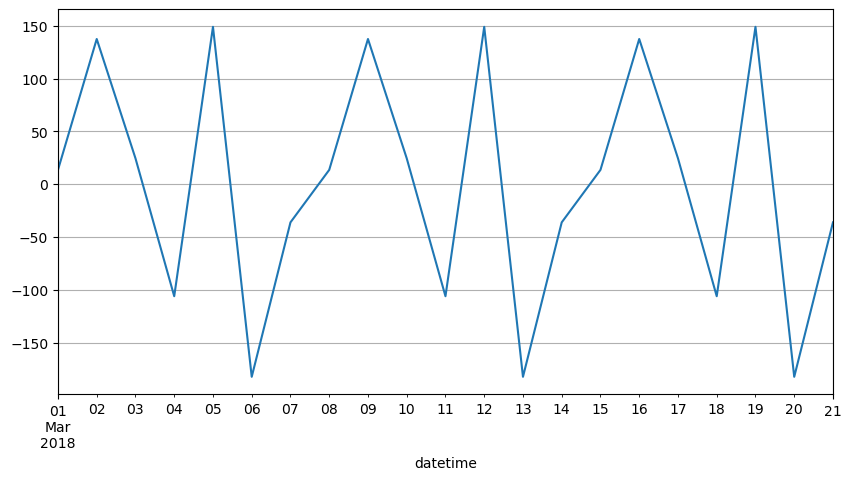

In [21]:
# Выведем график 'сезонности' на интервале в 3 недели, чтобы увидеть характерно повторяющиеся
# закономерности.

decomposed_day.seasonal['2018-03-01':'2018-03-21'].plot(ax=plt.gca(), figsize=size, grid=True)

В рамках недели также есть четкая зависимость кол-ва заказов от дня недели. Больше всего заказов в пятницу и понедельник, меньше всего в восресение и вторник.

## Обучение

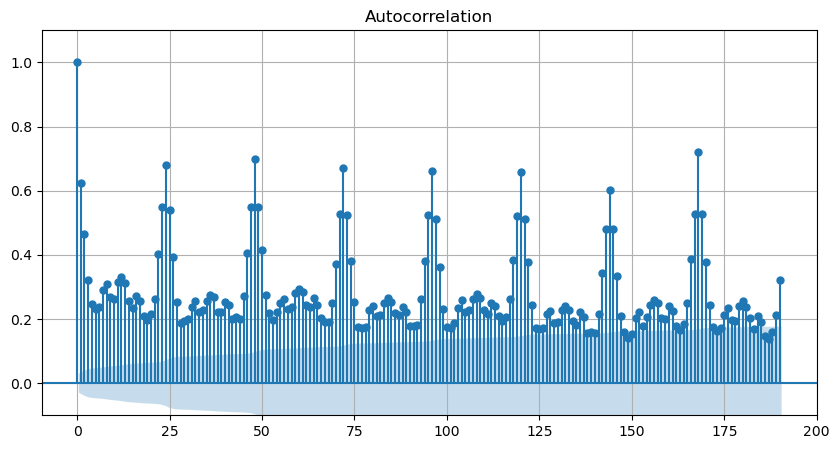

In [22]:
# Посмотрим на автокорреляцию.

ts = df['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(size)
plt.ylim(-.1, 1.1)
plt.grid(True)
plt.show() 

Мы провели анализ и выявили дневную и недельную сезонности. Соответственно, из лагов нам пригодится лаги предыдущего часа , предыдущего часа предыдущего дня (взяли 48 лагов, каждый со сдвигом на час по отношению к предыдущему) и один лаг недельной давности. 
Скользящее среднее при небольшом окне показывет кратковременные изменения (например, увеличение спроса на такси из-за изменений погоды). Возьмем размер окна равным 10.

In [23]:
# Функция для создания признаков и параметры скользящего среднего.

def make_features_1(data):
    data_m = data.copy(deep=True)
    data_m['day'] = data.index.day
    data_m['dayofweek'] = data.index.dayofweek
    data_m['hour'] = data.index.hour
    
    for lag in range(1, 48):
        data_m['lag_{}'.format(lag)] = data_m['num_orders'].shift(lag)

    data_m['167'] = data_m['num_orders'].shift(167)

    data_m['rolling_mean'] = data_m['num_orders'].shift().rolling(10).mean()
    return data_m

In [24]:
# Разобъем данные на обучающую и тестовую выборки, удалим появившиеся в результате сдвига пропуски.

data_1 = make_features_1(df)
train, test = train_test_split(data_1, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Модель линейной регрессии.

In [25]:
%%time
# Обучим модель линйеной регрессии  и проверим значение метрики на кросс-валидации.

lg_model = LinearRegression()
lg_scores = -cross_val_score(lg_model, features_train, target_train,\
                                  scoring='neg_root_mean_squared_error',\
                                  cv=TimeSeriesSplit(n_splits=5))
best_rmse_lg = lg_scores.mean()
print('Лучшее значение RMSE для линейной регрессии на кросс-валидации:', round(best_rmse_lg, 2))

Лучшее значение RMSE для линейной регрессии на кросс-валидации: 25.89
Wall time: 147 ms


### Модель Ridge.

In [26]:
%%time
# В цикле  при помощт кросс-валидации подберем оптимальные параметр регуляризации для модели Ridge. 

best_rmse_ridge = 100
for alpha in np.arange(0.1, 1.0, 0.1):
    ridge_model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    ridge_scores = -cross_val_score(ridge_model, features_train, target_train,\
                                  scoring='neg_root_mean_squared_error',\
                                  cv=TimeSeriesSplit(n_splits=5))
    rmse_ridge = ridge_scores.mean()
    print
    if rmse_ridge < best_rmse_ridge:
                best_rmse_ridge = rmse_ridge
                best_alpha = alpha
print('Лучшее значение RMSE для Ridge при кросс-валидации:', round(best_rmse_ridge, 2))
print('Лучшее значение alpha для Ridge при кросс-валидации:', best_alpha)

Лучшее значение RMSE для Ridge при кросс-валидации: 25.89
Лучшее значение alpha для Ridge при кросс-валидации: 0.9
Wall time: 683 ms


### Модель решающего дерева.

In [27]:
# В цикле при помощи кросс-валидации подберем оптимальную глубину дерева для модели решающего дерева.

best_rmse_tree = 100

for depth in range(2, 10, 2):
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    tree_scores = -cross_val_score(tree_model, features_train, target_train,\
                                  scoring='neg_root_mean_squared_error',\
                                  cv=TimeSeriesSplit(n_splits=5))
    rmse_tree = tree_scores.mean()
    if rmse_tree < best_rmse_tree:
        best_rmse_tree = rmse_tree
        best_depth = depth
print('Лучшее значение RMSE для решающего дерева при кросс-валидации ', round(best_rmse_tree, 2))
print('Лучшее значение глубины для решающего дерева при кросс-валидации:',best_depth)

Лучшее значение RMSE для решающего дерева при кросс-валидации  30.07
Лучшее значение глубины для решающего дерева при кросс-валидации: 4


### Модель Catboost.

In [28]:
# Параметры для RandomseachCV для модели CatBoostRegressor

param_cat = {
            'learning_rate': [0.1, 0.5],
            'iterations' : [50, 100]
            }

In [29]:
%%time
# Подберем оптимальные гиперпараметры для модели CatBoostRegressor, используя RandomseachCV. 

best_rmse_cat = 100


cat_regressor = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
cat = RandomizedSearchCV(cat_regressor,param_distributions=param_cat,\
                            n_jobs=-1, n_iter=4,cv=TimeSeriesSplit(n_splits=5),\
                         scoring='neg_root_mean_squared_error')
cat_model = cat.fit(features_train,target_train)
rmse_cat_model = -cat_model.best_score_
params_cat_model = cat_model.best_params_
if rmse_cat_model < best_rmse_cat:
    best_rmse_cat = rmse_cat_model
    best_cat_params = params_cat_model
print('Лучшее значение RMSE для CatboostRegression при кросс-валидации: ', round(best_rmse_cat, 2))
print('Лучшее гиперпараметры для CatboostRegression при кросс-валидации:', best_cat_params)

Лучшее значение RMSE для CatboostRegression при кросс-валидации:  24.7
Лучшее гиперпараметры для CatboostRegression при кросс-валидации: {'learning_rate': 0.1, 'iterations': 100}
Wall time: 23.6 s


## Тестирование

In [30]:
# Cоставим списки по результатам обучения и кросс-валидации моделей.

models = ['Линейная регрессия', 'Ridge', 'Решающее дерево', 'CatBoostRegressor']
res = [[best_rmse_lg],
        [best_rmse_ridge],
        [best_rmse_tree],
        [best_rmse_cat]]

In [31]:
# Создадим дата-фрейм с результатами кросс-валидации моделей.

result_data = pd.DataFrame(data=res, index=models, columns=['Качество предсказания (RMSE)'])
result_data

,Качество предсказания (RMSE)
Линейная регрессия,25.890349
Ridge,25.890634
Решающее дерево,30.072236
CatBoostRegressor,24.696097


Лучшие результаты показала модель CatBoostRegressor.

In [32]:
# Обучим модель c использованием лучших подобранных параметров и получим значение
# метрики на тестовой выборке.

final_model = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.1,\
                                iterations=100, verbose=False)
final_model.fit(features_train,target_train)
test_pred = final_model.predict(features_test)
final_rmse = mean_squared_error(test_pred, target_test)**0.5 
print('Значение RMSE лучшей из выбранных моделей на тестовой выборке:', round(final_rmse, 2))

Значение RMSE лучшей из выбранных моделей на тестовой выборке: 41.97


Проверим модель на адекватность.

In [33]:
# Обучим контстантную модель c использованием лучших подобранных параметров и получим значение
# метрики на тестовой выборке.

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train,target_train)
dummy_pred = dummy_model.predict(features_test)
dummy_rmse = mean_squared_error(dummy_pred, target_test)**0.5 
print('Значение RMSE константной модели на тестовой выборке:', round(dummy_rmse, 2))

Значение RMSE константной модели на тестовой выборке: 83.98


In [34]:
# Проверим адекватность модели, сравним значения полученного RSME со значением, полученным
# предсказанием по предыдущим значениям.

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
previous_rmse = mean_squared_error(pred_previous, target_test)**0.5 
print('Значение RMSE с предсказаниями на тестовой выборке по предыдущим:', round(previous_rmse, 2))

Значение RMSE с предсказаниями на тестовой выборке по предыдущим: 58.86


***Итоговый вывод:***

**Для лучшей из выбранных на кросс-валидации для задачи моделей (CatBoostRegressor) получили значение метрики на тестовой выборке равное 41,97, что удовлетворяет поставленной задаче и менее 48 и  превосходит как константную модель, так и предсказания, полученные по предыдущим значениям.**